Graph of optimal platoon size given mph and any given amount of cars

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
def optimal_platoon_size(num_cars, speed_limit_mph, comfort_time, accel_time_60, gap=None):
    """
    Estimate the optimal platoon size n* for a two-lane autonomous traffic merge.

    Parameters:
    - num_cars (int): Total number of cars in the traffic jam
    - speed_limit_mph (float): Speed limit in miles per hour
    - comfort_time (float): Comfort threshold in seconds
    - gap (float or None): Inter-platoon gap in seconds; if None, estimated based on speed_limit_mph
    -accel_time_60 (float): Acceleration time in seconds

    Returns:
    - float: Optimal platoon size (n*)
    """
    # Acceleration time (scaled from 0–60 mph in 7 sec)
    T_a = speed_limit_mph * (accel_time_60 / 60)

    # Inter-platoon gap scales with speed if not provided
    if gap is None:
        gap = 0.5 + (speed_limit_mph - 30) * (1.0 / 40)  # linear from 0.5 (30 mph) to 1.5 (70 mph)

    # Overhead time per platoon
    T_overhead = T_a + gap

    # Rule of thumb
    return max(1, int(min(num_cars / 2, comfort_time / T_overhead)))

def plot_optimal_platoon_vs_N(speed_limit_mph, comfort_time, max_N, accel_time_60):
    """
    Plot optimal platoon size vs. number of cars in traffic jam.

    Parameters:
    - speed_limit_mph (float): Speed limit in miles per hour
    - C (float): Comfort threshold in seconds
    - max_N (int): Maximum traffic jam size to plot
    """
    Ns = np.arange(60, max_N + 1)
    n_stars = [optimal_platoon_size(num_cars, speed_limit_mph, comfort_time,accel_time_60) for num_cars in Ns]

    plt.figure(figsize=(12, 6))
    plt.plot(Ns, n_stars, color='blue')
    plt.title(f"Optimal Platoon Size vs. Traffic Jam Size (speed limit={speed_limit_mph}mph, Comfort wait time ={comfort_time}s, 0-60 accel = {accel_time_60}s)")
    plt.xlabel("Number of Cars in Traffic Jam (N)")
    plt.ylabel("Optimal Platoon Size (n*)")

    # Find the point where the optimal platoon size stops increasing
    plateau_N = 0
    for i in range(1, len(n_stars)):
        if n_stars[i] > n_stars[i-1]:
             # The plateau starts when the value stops increasing
             continue
        elif n_stars[i] == n_stars[i-1] and i > 0 and n_stars[i] == max(n_stars):
             # Found the first point of the plateau at the maximum value
             plateau_N = Ns[i-1]
             break

    # If no clear plateau at the maximum value, it might be at the end of the range
    if plateau_N == 0 and len(n_stars) > 0 and n_stars[-1] == max(n_stars):
        # Find the first N where the max value is reached
        for i in range(len(n_stars)):
            if n_stars[i] == max(n_stars):
                plateau_N = Ns[i]
                break


    # Add a dashed line at the plateau point
    if plateau_N > 0:
        plt.axvline(plateau_N, linestyle='--', color='red', label=f'Plateau at N = {plateau_N}')


    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:

import math
def average_individual_mph_with_wait_optimal(
    num_cars,
    bottleneck_length_miles,
    car_length,
    speed_limit_mph,
    accel_time_60,
    comfort_time,
    gap=None,
    delta=0.1
):
    """
    Computes the average speed (mph) of individual cars through a bottleneck + waiting area.

    Parameters:
    - num_cars: total cars in the traffic jam
    - bottleneck_length_miles: length of the actual narrow region (2 lanes → 1)
    - car_length: average length of a car in miles
    - speed_limit_mph: the max speed limit allowed
    - accel_time_60: how long it takes to reach 60 mph from rest
    - delta: time gap (sec) between cars within the same platoon
    - comfort_time: max time (sec) the opposite lane is willing to wait
    - gap: time gap (sec) between platoons (optional; scales with speed_limit_mph by default)

    Returns:
    - average mph across all cars, including time spent waiting to go
    """
    waiting_queue_length_miles = car_length * (num_cars - 1)

    # Step 1: Compute optimal platoon size using your provided formula
    platoon_size = int(optimal_platoon_size(num_cars, speed_limit_mph, comfort_time, accel_time_60, gap))

    # Step 2: Total distance each car travels = bottleneck + the queue behind it
    total_distance = bottleneck_length_miles + waiting_queue_length_miles

    # Step 3: Estimate time for first car in each platoon to pass bottleneck
    # Assume half of bottleneck is used to accelerate to cruising speed
    accel_distance = 0.5 * speed_limit_mph * (accel_time_60 / 3600)  # in miles

    if accel_distance >= bottleneck_length_miles:
        # Bottleneck is too short for full acceleration; estimate using physics
        time_for_first_car = math.sqrt(
            2 * bottleneck_length_miles / ((speed_limit_mph * 1609.34) / (accel_time_60 ** 2))
        )
    else:
        # Full acceleration then coasting at speed_limit
        coast_speed_mps = speed_limit_mph * 1609.34 / 3600
        coast_distance = bottleneck_length_miles - accel_distance
        coast_time = coast_distance / coast_speed_mps
        time_for_first_car = accel_time_60 + coast_time  # total time to exit

    # Step 4: Set up time tracking for each platoon
    if gap is None:
        gap = 0.5 + (speed_limit_mph - 30) * (1.0 / 40)  # default inter-platoon gap

    current_time = 0  # when each platoon starts
    car_speeds = []
    cars_processed = 0
    num_platoons = math.ceil(num_cars / platoon_size)

    # 🧮 Step 5: Simulate each car's time and compute its speed
    for _ in range(num_platoons):
        current_platoon = min(platoon_size, num_cars - cars_processed)
        for j in range(current_platoon):
            # Each car in platoon waits j * delta after the platoon begins
            car_start_time = current_time + j * delta
            total_time = car_start_time  # total time from simulation start
            current_mph = (3600 * total_distance) / total_time if total_time > 0 else 0
            car_speeds.append(min(current_mph, speed_limit_mph))  # cap at legal limit
        # Advance time for the next platoon
        current_time += time_for_first_car + (current_platoon - 1) * delta + gap
        cars_processed += current_platoon

    # Step 6: Average all the individual car speeds
    return sum(car_speeds) / len(car_speeds)

In [ ]:
# Create graph: comfort time vs average speed
def plot_comfort_time_vs_mph(
    num_cars,
    bottleneck_length_miles,
    car_length,
    speed_limit_mph,
    accel_time_60,
    comfort_time
):
    comfort_times = np.arange(10, (best_comfort_time(num_cars,bottleneck_length_miles,car_length,
    speed_limit_mph,
    accel_time_60)+10), 10)
    avg_speeds = []

    for C in comfort_times:
        mph = average_individual_mph_with_wait_optimal(
            num_cars=num_cars,
            bottleneck_length_miles=bottleneck_length_miles,
            car_length=car_length,
            speed_limit_mph=speed_limit_mph,
            accel_time_60=accel_time_60,
            comfort_time=C
        )
        avg_speeds.append(mph)

    current_comfort_time = average_individual_mph_with_wait_optimal(
            num_cars,
            bottleneck_length_miles,
            car_length,
            speed_limit_mph,
            accel_time_60,
            comfort_time
        )
    stoplight_comfort_time = average_individual_mph_with_wait_optimal(
            num_cars,
            bottleneck_length_miles,
            car_length,
            speed_limit_mph,
            accel_time_60,
            comfort_time=60
        )
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(comfort_times, avg_speeds, marker='o', color='purple')
    plt.axvline(60, linestyle = "--", color='red', label= f"average time at stoplight: 60s (Avg MPH: {stoplight_comfort_time}")
    plt.axvline(comfort_time, linestyle = "--", color='purple', label= f'Current Comfort Time: {comfort_time}s (Avg MPH: {current_comfort_time})')


    # Add a dashed line at the largest average mph
    max_avg_mph = max(avg_speeds)
    # Find the comfort time at which the max speed is reached
    optimal_comfort_time = comfort_times[avg_speeds.index(max_avg_mph)]
    plt.axvline(optimal_comfort_time, linestyle='--', color='blue', label=f'Optimal Comfort Time: {optimal_comfort_time}s (Avg MPH: {max_avg_mph:.2f})')

    plt.title(f"Average Speed vs. Comfort Time (for {num_cars} Cars, 0-60 accel = {accel_time_60}, {speed_limit_mph} speed limit)")
    plt.xlabel("Comfort Time (seconds)")
    plt.ylabel("Average Speed (mph)")
    plt.grid(True)
    plt.legend() # Add legend to show labels for the lines
    plt.tight_layout()
    plt.show()

def best_comfort_time(num_cars,
    bottleneck_length_miles,
    car_length,
    speed_limit_mph,
    accel_time_60
):
    comfort_times = np.arange(10, (num_cars), 10)
    avg_speeds = []
    for C in comfort_times:
        mph = average_individual_mph_with_wait_optimal(
            num_cars=num_cars,
            bottleneck_length_miles=bottleneck_length_miles,
            car_length=car_length,
            speed_limit_mph=speed_limit_mph,
            accel_time_60=accel_time_60,
            comfort_time=C
        )
        avg_speeds.append(mph)
        max_avg_mph = max(avg_speeds)
    # Find the comfort time at which the max speed is reached
    optimal_comfort_time = comfort_times[avg_speeds.index(max_avg_mph)]
    return optimal_comfort_time




GRAPH for average mph by Hour of the day (deterministic busy times) add agrapg for wait time/sojourn time

In [ ]:



def time_to_complete_bottleneck(
      num_cars,
      bottleneck_length_miles,
      car_length,
      speed_limit_mph,
      comfort_time,
      accel_time_60,
      delta=0.1,
      gap=None
  ):
      """
      Calculates the total time for all cars to clear the bottleneck and the number of cars remaining after 60 minutes.

      Parameters:
      - num_cars: total cars in the traffic jam
      - bottleneck_length_miles: length of the actual narrow region (2 lanes → 1)
      - car_length: average length of a car in miles
      - speed_limit_mph: the max speed limit allowed
      - accel_time_60: how long it takes to reach 60 mph from rest
      - delta: time gap (sec) between cars within the same platoon
      - comfort_time: max time (sec) the opposite lane is willing to wait
      - gap: time gap (sec) between platoons (optional; scales with speed_limit_mph by default)

      Returns:
      - tuple: (total time to clear bottleneck in seconds, number of cars remaining after 3600 seconds)
      """
      # Step 1: Compute optimal platoon size
      platoon_size = int(optimal_platoon_size(num_cars, speed_limit_mph, comfort_time, accel_time_60, gap))

      # Step 2: Estimate time for first car in each platoon to pass bottleneck
      T_a = speed_limit_mph * (accel_time_60 / 60) # Time to reach speed limit in seconds
      accel_distance = 0.5 * speed_limit_mph * (T_a / 3600)  # in miles

      if accel_distance >= bottleneck_length_miles:
          # Bottleneck is too short for full acceleration; estimate using physics
          time_for_first_car = math.sqrt(
              2 * bottleneck_length_miles / ((speed_limit_mph * 1609.34) / (accel_time_60 ** 2))
          )
      else:
          # Full acceleration then coasting at speed_limit
          coast_speed_mps = speed_limit_mph * 1609.34 / 3600
          coast_distance = bottleneck_length_miles - accel_distance
          coast_time = coast_distance / coast_speed_mps
          time_for_first_car = accel_time_60 + coast_time  # total time to exit

      # Step 3: Set up time tracking for each platoon
      if gap is None:
          gap = 0.5 + (speed_limit_mph - 30) * (1.0 / 40)  # default inter-platoon gap

      current_time = 0  # when each platoon starts
      cars_processed = 0
      num_platoons = math.ceil(num_cars / platoon_size)
      time_list = []

      # Step 4: Simulate each car's time
      for _ in range(num_platoons):
          current_platoon = min(platoon_size, num_cars - cars_processed)
          for j in range(current_platoon):
              car_start_time = current_time + j * delta
              time_list.append(car_start_time + time_for_first_car) # Time when the car clears the bottleneck
          current_time += time_for_first_car + (current_platoon - 1) * delta + gap
          cars_processed += current_platoon

      total_time_to_clear = time_list[-1] if time_list else 0

      # Calculate cars remaining after 60 minutes (3600 seconds)
      cars_after_60_min = sum(1 for t in time_list if t > 3600)

      return total_time_to_clear, cars_after_60_min

def plot_cars_vs_time_to_clear(
    num_cars_range,
    bottleneck_length_miles,
    car_length,
    speed_limit_mph,
    comfort_time,
    accel_time_60,
    gap,
    delta=0.1,
):
    """
    Plots the number of cars vs. the time it takes to clear the bottleneck.

    Parameters:
    - num_cars_range (list or array): A list or array of the number of cars to simulate.
    - bottleneck_length_miles (float): Length of the actual narrow region.
    - car_length (float): Average length of a car in miles.
    - speed_limit_mph (float): The max speed limit allowed.
    - comfort_time (float): Max time (sec) the opposite lane is willing to wait.
    - accel_time_60 (float): How long it takes to reach 60 mph from rest.
    - delta (float): Time gap (sec) between cars within the same platoon (default: 0.1).
    - gap (float or None): Time gap (sec) between platoons (optional; scales with speed_limit_mph by default).
    """
    clearance_times_minutes = []
    for n in num_cars_range:
        total_time_seconds, _ = time_to_complete_bottleneck(
            num_cars=n,
            bottleneck_length_miles=bottleneck_length_miles,
            car_length=car_length,
            speed_limit_mph=speed_limit_mph,
            comfort_time=comfort_time,
            accel_time_60=accel_time_60,
            delta=delta,
            gap=gap
        )
        clearance_times_minutes.append(total_time_seconds / 60) # Convert seconds to minutes

    plt.figure(figsize=(10, 6))
    plt.plot(num_cars_range, clearance_times_minutes, color='red', linewidth=2)
    plt.title(f"Time to Clear Bottleneck vs Number of Cars (speed limit= {speed_limit_mph} mph, Comfort wait time ={comfort_time}s, 0-60 accel = {accel_time_60}s)")
    plt.xlabel("Number of Cars")
    plt.ylabel("Time to Clear Bottleneck (minutes)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()







In [ ]:
import numpy as np

def average_speeds_to_percentages(speeds, speed_limit_mph):
    """
    Converts a list of average speeds per hour into a list of percentages
    representing the relative traffic volume per hour, considering the speed limit.

    Parameters:
    - speeds (list or np.array): A list or numpy array of 24 average speeds
                                 for each hour of the day.
    - speed_limit_mph (float): The speed limit in miles per hour.

    Returns:
    - list: A list of 24 percentages (0-100) representing the relative
            traffic volume per hour. Lower speed relative to the speed limit
            means higher relative volume. The percentages are normalized to sum to 100.
    """
    # Calculate the difference from the speed limit to represent congestion
    # A larger difference (lower speed) means higher congestion/volume
    congestion_indicator = speed_limit_mph - np.array(speeds)

    # Ensure congestion indicator is not negative (speeds cannot exceed speed limit significantly)
    congestion_indicator[congestion_indicator < 0] = 0


    # Add a small epsilon to avoid division by zero if all speeds are at the speed limit
    # Normalize the congestion indicators to get relative volumes
    total_congestion = np.sum(congestion_indicator)
    if total_congestion == 0:
        # If no congestion (all speeds at or above limit), distribute volume equally
        relative_volumes = np.ones(len(speeds)) / len(speeds) * 100
    else:
        relative_volumes = (congestion_indicator / total_congestion) * 100


    return relative_volumes.tolist()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math


def average_mph_over24hrs_compounding(
    num_cars,
    hourly_cars_rate,
    bottleneck_length_miles,
    car_length,
    speed_limit_mph,
    accel_time_60,
    comfort_time,
    delta,
    gap
):
    """
    Simulates car traffic through a bottleneck over 24 hours, considering hourly
    arrival rates and calculating cars remaining at the end of each hour,
    the average wait time per hour, and average speed per hour.

    Parameters:
    - num_cars (int): Initial total number of cars.
    - hourly_cars_rate (list): List of 24 percentages representing the hourly
                               arrival rate relative to num_cars.
    - bottleneck_length_miles (float): Length of the bottleneck in miles.
    - car_length (float): Average length of a car in miles.
    - speed_limit_mph (float): Speed limit in mph.
    - accel_time_60 (float): Time to accelerate from 0 to 60 mph in seconds.
    - comfort_time (float): Comfort threshold in seconds.
    - delta (float): Time gap between cars within a platoon in seconds.
    - gap (float or None): Time gap between platoons in seconds.

    Returns:
    - tuple: (list of number of cars remaining at the end of each hour,
              list of average wait time per hour in seconds,
              list of average speed per hour in mph)
    """
    cars_remaining_per_hour = []
    average_wait_time_per_hour = []
    average_speed_per_hour = []
    remaining_cars = 0

    for hour in range(24):
        # Calculate the number of cars arriving in the current hour
        arriving_cars = int((num_cars / 100) * hourly_cars_rate[hour])

        # Total cars to process in this hour = remaining cars from previous hour + arriving cars
        total_cars_this_hour = remaining_cars + arriving_cars

        if total_cars_this_hour == 0:
            cars_remaining_per_hour.append(0)
            average_wait_time_per_hour.append(0)
            average_speed_per_hour.append(speed_limit_mph) # Assume free flow if no cars
            remaining_cars = 0
            continue


        # Step 1: Compute optimal platoon size
        platoon_size = int(optimal_platoon_size(total_cars_this_hour, speed_limit_mph, comfort_time, accel_time_60, gap))

        # Step 2: Estimate time for first car in each platoon to pass bottleneck
        T_a = speed_limit_mph * (accel_time_60 / 60) # Time to reach speed limit in seconds
        accel_distance = 0.5 * speed_limit_mph * (T_a / 3600)  # in miles

        if accel_distance >= bottleneck_length_miles:
            # Bottleneck is too short for full acceleration; estimate using physics
            time_for_first_car_bottleneck = math.sqrt(
                2 * bottleneck_length_miles / ((speed_limit_mph * 1609.34) / (accel_time_60 ** 2))
            )
        else:
            # Full acceleration then coasting at speed_limit
            coast_speed_mps = speed_limit_mph * 1609.34 / 3600
            coast_distance = bottleneck_length_miles - accel_distance
            coast_time = coast_distance / coast_speed_mps
            time_for_first_car_bottleneck = accel_time_60 + coast_time  # total time to exit

        # Step 3: Set up time tracking for each platoon
        if gap is None:
            gap = 0.5 + (speed_limit_mph - 30) * (1.0 / 40)  # default inter-platoon gap

        current_hour_start_time = hour * 3600 # Time in seconds from the beginning of the 24 hour simulation
        platoon_enter_time = current_hour_start_time # When the first car of the current platoon enters the bottleneck area

        cars_in_this_hour_processed = 0
        num_platoons = math.ceil(total_cars_this_hour / platoon_size)
        hourly_wait_times = []
        hourly_travel_times = []
        hourly_total_times = [] # To store total time for each car (wait + travel)
        hourly_distances_traveled = [] # To store distance traveled by each car


        # Simulate each car's time and calculate wait time
        for _ in range(num_platoons):
            current_platoon = min(platoon_size, total_cars_this_hour - cars_in_this_hour_processed)
            if current_platoon <= 0:
                break # No more cars to process

            for j in range(current_platoon):
                car_enter_time = platoon_enter_time + j * delta
                wait_time = car_enter_time - (hour * 3600) # Wait time is relative to the start of the current hour
                hourly_wait_times.append(max(0, wait_time)) # Ensure wait time is not negative

                # Calculate travel time through the bottleneck for this car
                # Assuming travel time is roughly constant for all cars once they enter
                travel_time_bottleneck = time_for_first_car_bottleneck # Simplified travel time
                hourly_travel_times.append(travel_time_bottleneck)
                hourly_total_times.append(max(0, wait_time) + travel_time_bottleneck) # Total time is wait time + travel time
                # Distance traveled by each car includes bottleneck length plus the length of cars ahead of it
                distance_traveled = bottleneck_length_miles # Only bottleneck length for speed calculation
                hourly_distances_traveled.append(distance_traveled)


            # Advance time for the next platoon
            platoon_enter_time += time_for_first_car_bottleneck + (current_platoon - 1) * delta + gap
            cars_in_this_hour_processed += current_platoon


        # Calculate cars remaining after 60 minutes (3600 seconds from the start of the current hour)
        # This calculation needs to be more accurate. It should count how many cars *started* within the hour
        # and *finished* within the hour.

        cars_cleared_this_hour = 0
        time_threshold = hour * 3600 + 3600 # End of the current hour in seconds from sim start
        simulated_car_exit_times = []
        current_sim_time = hour * 3600 # Start of the current hour in seconds

        platoon_start_sim_time = current_sim_time
        cars_processed_in_sim = 0


        num_platoons_to_consider = math.ceil(total_cars_this_hour / platoon_size)


        for p in range(num_platoons_to_consider):
            current_platoon_sim = min(platoon_size, total_cars_this_hour - cars_processed_in_sim)
            if current_platoon_sim <= 0:
                break # No more cars to process

            for c in range(current_platoon_sim):
                car_enter_sim_time = platoon_start_sim_time + c * delta
                car_exit_sim_time = car_enter_sim_time + time_for_first_car_bottleneck # Assuming roughly constant travel time once entered
                simulated_car_exit_times.append(car_exit_sim_time)
                if car_exit_sim_time <= time_threshold:
                    cars_cleared_this_hour += 1


            platoon_start_sim_time += time_for_first_car_bottleneck + (current_platoon_sim - 1) * delta + gap
            cars_processed_in_sim += current_platoon_sim


        remaining_cars = total_cars_this_hour - cars_cleared_this_hour
        cars_remaining_per_hour.append(remaining_cars)

        # Calculate average wait time for the cars that *were considered* in this hour
        avg_wait_this_hour = sum(hourly_wait_times) / len(hourly_wait_times) if hourly_wait_times else 0
        average_wait_time_per_hour.append(avg_wait_this_hour)

        # Calculate average speed for cars that cleared within the hour or were considered in this hour
        # This is a simplified average speed calculation. A more accurate one would consider the actual travel time for each car.
        # Using cars cleared and bottleneck length for a rough estimate
        if cars_cleared_this_hour > 0:
             # Time taken for the cleared cars to travel the bottleneck length
            time_taken_cleared_cars = cars_cleared_this_hour * (time_for_first_car_bottleneck + (platoon_size - 1) * delta + gap) / platoon_size # Approximation
            # Average speed is total distance (bottleneck length) divided by average time taken
            avg_speed_this_hour = (bottleneck_length_miles / (time_taken_cleared_cars / 3600)) if time_taken_cleared_cars > 0 else speed_limit_mph
        else:
            avg_speed_this_hour = 0 # If no cars cleared, average speed is 0

        average_speed_per_hour.append(min(avg_speed_this_hour, speed_limit_mph)) # Cap at speed limit


    return cars_remaining_per_hour, average_wait_time_per_hour, average_speed_per_hour


# Example code for 100 cars, 65mph, 7 second 0-60 acceleration




In [ ]:
#7 lanes on GW, 14 from SR4, 150,000 cars on there a day, 21,500 aprrox in each of the 7 lanes a day
from re import A
# ATRI Fort-Lee observed speeds by hour (digitized)
ATRI_SPEED = np.array([
    32, 38, 40, 40, 35, 35, 20, 18,
    15, 20, 24, 25, 26, 27, 26, 26,
    26, 24, 25, 29, 34, 39, 31, 25
])
# Initialize variables with example values for all functions
num_cars_GWI_95 = 21500
speed_limit_mph_GWI_95 = 60
comfort_time_GWI_95 = 90
accel_time_60_GWI_95 = 7.0
bottleneck_length_miles_GWI_95 = 2
car_length_GWI_95 = 0.003
delta_GWI_95 = 0.1
gap_GWI_95 =1 # or a specific value if needed
hourly_cars_rate_GWI_95 = average_speeds_to_percentages(ATRI_SPEED,speed_limit_mph_GWI_95)
num_cars_range=list(range(1, num_cars_GWI_95+1))
best_comfort_time_GWI_95 = best_comfort_time(num_cars_GWI_95,bottleneck_length_miles_GWI_95,car_length_GWI_95,speed_limit_mph_GWI_95,accel_time_60_GWI_95)


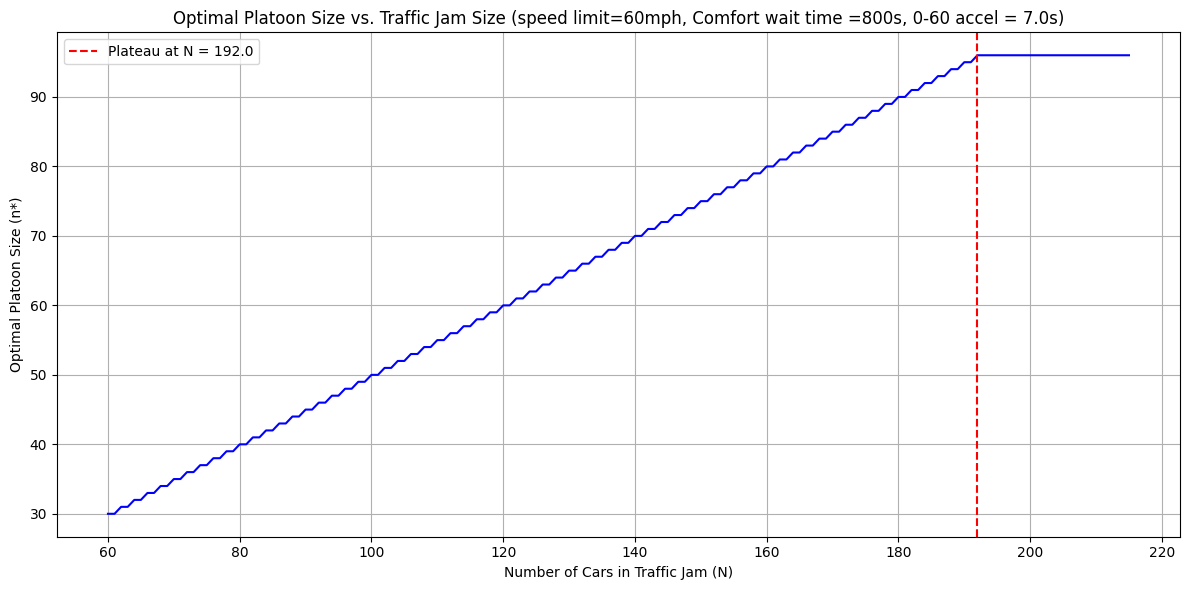

In [ ]:
# optimal platoon size based on #cars and comfort time
plot_optimal_platoon_vs_N(speed_limit_mph_GWI_95, best_comfort_time_GWI_95, num_cars_GWI_95/100, accel_time_60_GWI_95)

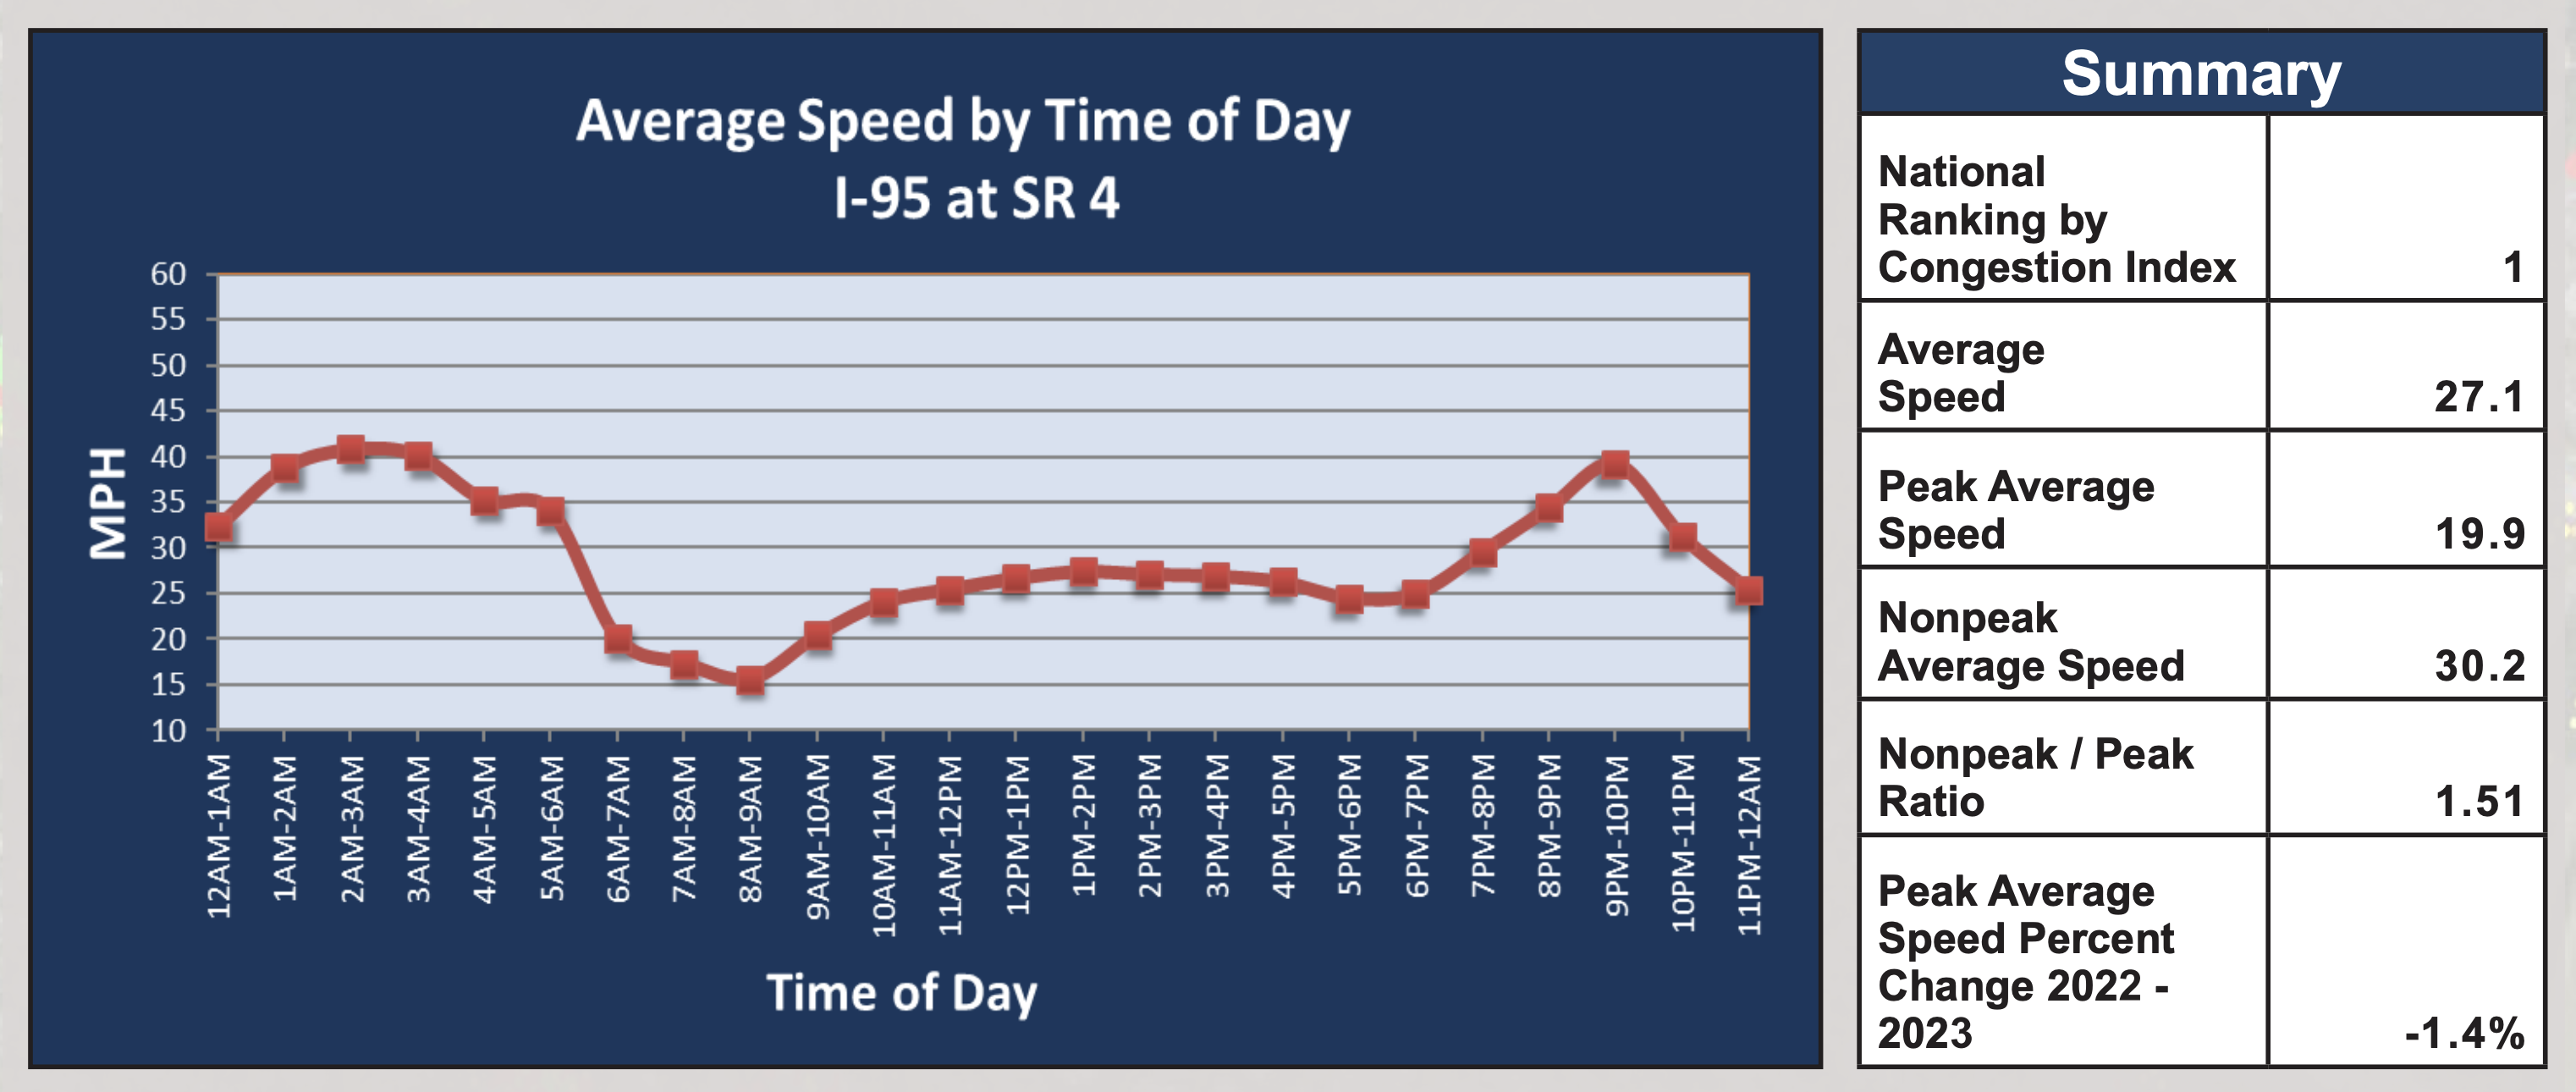

In [ ]:


#time to clear traffic with best comfort time
plot_cars_vs_time_to_clear(num_cars_range,
    bottleneck_length_miles_GWI_95,
    car_length_GWI_95,
    speed_limit_mph_GWI_95,
    best_comfort_time_GWI_95,
    accel_time_60_GWI_95,
    delta_GWI_95,
    gap_GWI_95
)



A larger comfort time of drivers allow speeds to go up until some caps depending on amount of cars. !SUPER IMPORTANT! people will have to wait longer to go but overall flow and average MPH will improve


In [ ]:

#test total time of bottleneck function
print(time_to_complete_bottleneck(num_cars_GWI_95,bottleneck_length_miles_GWI_95,car_length_GWI_95,speed_limit_mph_GWI_95,comfort_time_GWI_95,accel_time_60_GWI_95))

# Example of how comfort time affects the average mph through the bottle neck
plot_comfort_time_vs_mph(num_cars_GWI_95,bottleneck_length_miles_GWI_95,car_length_GWI_95,speed_limit_mph_GWI_95,accel_time_60_GWI_95,comfort_time_GWI_95)


In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define a function to fit the curve to. A sigmoid function might be appropriate.
def sigmoid(x, L ,x0, k, b):
    return L / (1 + np.exp(-k*(x-x0))) + b

# Generate the data for curve fitting
comfort_times_for_fit = np.arange(10, (num_cars_GWI_95/2), 10)
avg_speeds_for_fit = []

for C in comfort_times_for_fit:
    mph = average_individual_mph_with_wait_optimal(
        num_cars=20000,
        bottleneck_length_miles=bottleneck_length_miles_GWI_95,
        car_length=car_length_GWI_95,
        speed_limit_mph=speed_limit_mph_GWI_95,
        accel_time_60=accel_time_60_GWI_95,
        comfort_time=C
    )
    avg_speeds_for_fit.append(mph)

# Fit the curve
# Initial guess for the parameters (L, x0, k, b)
# L: max speed, x0: comfort time at midpoint, k: steepness, b: min speed
# Adjusted initial guess based on the plot characteristics
p0 = [speed_limit_mph_GWI_95, 1000, 0.005, 10] # Adjusted p0 values
params, cov = curve_fit(sigmoid, comfort_times_for_fit, avg_speeds_for_fit, p0=p0, maxfev=5000) # Increased maxfev

# Extract the fitted parameters
L_fit, x0_fit, k_fit, b_fit = params

print(f"Fitted function: f(C) = {L_fit:.2f} / (1 + exp(-{k_fit:.4f} * (C - {x0_fit:.2f}))) + {b_fit:.2f}")

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(comfort_times_for_fit, avg_speeds_for_fit, label='Original Data', color='purple', s=10)
plt.plot(comfort_times_for_fit, sigmoid(comfort_times_for_fit, *params), label='Fitted Curve', color='red')
plt.title("Average Speed vs. Comfort Time with Fitted Curve")
plt.xlabel("Comfort Time (seconds)")
plt.ylabel("Average Speed (mph)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

This is a comparision of some arbritrary random amount of vehciles present, based on an estimation of busy hours, we would add a probability model here based on the data below instead!!!!


In [ ]:
# Test with GWI_95 data
cars_remaining_per_hour_results, avg_wait_time_per_hour, avg_speed_per_hour = average_mph_over24hrs_compounding(
    num_cars_GWI_95,
    hourly_cars_rate_GWI_95,
    bottleneck_length_miles_GWI_95,
    car_length_GWI_95,
    speed_limit_mph_GWI_95,
    accel_time_60_GWI_95,
    best_comfort_time_GWI_95,
    delta_GWI_95,
    gap_GWI_95
)

# Plot Average Speed per Hour
hours = list(range(24))
plt.figure(figsize=(12, 6))
plt.plot(hours, avg_speed_per_hour, marker='o', color='green', label='Optimized (Simulated)')
plt.plot(hours, ATRI_SPEED, marker='o', color='purple', label='ATRI Fort Lee GW Data')
plt.title("Average Speed (mph) by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Speed (mph)")
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.legend() # Added legend here
plt.tight_layout()
plt.show()

# Convert average wait time to minutes
avg_wait_time_per_hour_minutes = [t / 60 for t in avg_wait_time_per_hour]

# Plot Average Wait Time per Hour in Minutes
plt.figure(figsize=(12, 6))
plt.suptitle("Average Wait Time (minutes) by Hour of Day", y=1.02) # Add suptitle
plt.title("Average wait time is the average time each car spends waiting before entering the bottleneck during that hour.", fontsize=10) # Add explanation as title
plt.plot(hours, avg_wait_time_per_hour_minutes, marker='x', color='red')
plt.xlabel("Hour of Day")
plt.ylabel("Average Wait Time (minutes)")
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Number of cars remaining per hour: {cars_remaining_per_hour_results}")
print(f"Average wait time per hour (minutes): {[f'{t:.2f}' for t in avg_wait_time_per_hour_minutes]}")
print(f"Average speed per hour: {[f'{s:.2f}' for s in avg_speed_per_hour]}")

In [ ]:
def average_speed_difference(atri_speeds, simulated_speeds):
    """
    Calculates the average absolute difference between ATRI speeds and simulated speeds.

    Parameters:
    - atri_speeds (list or np.array): A list or numpy array of 24 ATRI speeds.
    - simulated_speeds (list or np.array): A list or numpy array of 24 simulated average speeds per hour.

    Returns:
    - float: The average absolute difference between the two sets of speeds.
    """
    if len(atri_speeds) != 24 or len(simulated_speeds) != 24:
        raise ValueError("Both ATRI speeds and simulated speeds must have 24 values (one for each hour).")

    differences = np.abs(np.array(atri_speeds) - np.array(simulated_speeds))
    return np.mean(differences)

# Calculate and print the average speed difference
avg_diff = average_speed_difference(ATRI_SPEED, avg_speed_per_hour)
print(f"Average absolute difference between ATRI speeds and simulated speeds: {avg_diff:.2f} mph")

In [ ]:
def average_percentage_increase(original_speeds, optimized_speeds):
    """
    Calculates the average percentage increase from original speeds to optimized speeds.

    Parameters:
    - original_speeds (list or np.array): A list or numpy array of original speeds (e.g., ATRI data).
    - optimized_speeds (list or np.array): A list or numpy array of optimized speeds (e.g., simulated data).

    Returns:
    - float: The average percentage increase. Returns 0 if original_speeds contains zeros to avoid division by zero.
    """
    if len(original_speeds) != len(optimized_speeds) or len(original_speeds) == 0:
        raise ValueError("Both speed lists must have the same non-zero length.")

    percentage_increases = []
    for original, optimized in zip(original_speeds, optimized_speeds):
        if original == 0:
            # Handle cases where original speed is 0 to avoid division by zero
            percentage_increase = 0 if optimized == 0 else float('inf') # Or handle as appropriate
        else:
            percentage_increase = ((optimized - original) / original) * 100
        percentage_increases.append(percentage_increase)

    # Filter out infinite values if any, before calculating the mean
    finite_increases = [p for p in percentage_increases if p != float('inf')]

    return np.mean(finite_increases) if finite_increases else 0

# Calculate and print the average percentage increase in speed
avg_percent_increase = average_percentage_increase(ATRI_SPEED, avg_speed_per_hour)
print(f"Average percentage increase in speed: {avg_percent_increase:.2f}%")

# Code Grave yard

In [ ]:
'''
import matplotlib.pyplot as plt
import numpy as np



# Plot function for 24-hour average speeds
def plot_24h_average_speed(
    num_cars,
    hourly_cars_rate,
    bottleneck_length_miles,
    car_length,
    speed_limit_mph,
    accel_time_60,
    comfort_time,
    ATRI_SPEED,
    delta=0.1
):
    assert len(hourly_cars_rate) == 24, "hourly_cars must be a list of 24 values."
    assert len(ATRI_SPEED) ==24
    hourly_cars= [(num_cars/100)*carrate for carrate in hourly_cars_rate]
    speeds = []
    for carrate in hourly_cars:
        avg_mph = average_individual_mph_with_wait_optimal(
            num_cars=int(carrate),
            bottleneck_length_miles=bottleneck_length_miles,
            car_length=car_length,
            speed_limit_mph=speed_limit_mph,
            accel_time_60=accel_time_60,
            delta=delta,
            comfort_time=comfort_time
        )
        speeds.append(avg_mph)

    hours = list(range(24))
    plt.figure(figsize=(12, 6))
    plt.plot(hours, speeds, marker='o', color='green')
    plt.plot(hours, ATRI_SPEED, marker='o', color='red')
    plt.title("Average Speed (mph) by Hour of Day (Includes Wait Time + Bottleneck)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Speed (mph)")
    plt.xticks(np.arange(0, 24, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
'''
def plot_avg_mph_vs_num_cars(
    num_cars_range,
    bottleneck_length_miles,
    car_length,
    speed_limit_mph,
    accel_time_60,
    comfort_time,
    delta=0.1,
    gap=None
):
    """
    Plots the average individual MPH vs. the number of cars in the bottleneck.

    Parameters:
    - num_cars_range (list or array): A list or array of the number of cars to simulate.
    - bottleneck_length_miles (float): Length of the actual narrow region.
    - car_length (float): Average length of a car in miles.
    - speed_limit_mph (float): The max speed limit allowed.
    - accel_time_60 (float): How long it takes to reach 60 mph from rest.
    - comfort_time (float): Max time (sec) the opposite lane is willing to wait.
    - delta (float): Time gap (sec) between cars within the same platoon (default: 0.1).
    - gap (float or None): Time gap (sec) between platoons (optional; scales with speed_limit_mph by default).
    """
    avg_mphs = [average_individual_mph_with_wait_optimal(
        num_cars=n,
        bottleneck_length_miles=bottleneck_length_miles,
        car_length=car_length,
        speed_limit_mph=speed_limit_mph,
        accel_time_60=accel_time_60,
        comfort_time=comfort_time,
        delta=delta,
        gap=gap
    ) for n in num_cars_range]

    plt.figure(figsize=(10, 6))
    plt.plot(num_cars_range, avg_mphs, color='blue', linewidth=2)
    plt.title(f"Average MPH vs Number of Cars in Bottleneck (speed limit= {speed_limit_mph} mph, Comfort wait time ={comfort_time}s, 0-60 accel = {accel_time_60}s)")
    plt.xlabel("Number of Cars")
    plt.ylabel("Average Individual MPH (Including Wait Time)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def time_to_complete_bottleneck(
    num_cars,
    bottleneck_length_miles,
    car_length,
    speed_limit_mph,
    comfort_time,
    accel_time_60,
    delta=0.1,
    gap=None
):
    """
    Calculates the total time for all cars to clear the bottleneck and the number of cars remaining after 60 minutes.

    Parameters:
    - num_cars: total cars in the traffic jam
    - bottleneck_length_miles: length of the actual narrow region (2 lanes → 1)
    - car_length: average length of a car in miles
    - speed_limit_mph: the max speed limit allowed
    - accel_time_60: how long it takes to reach 60 mph from rest
    - delta: time gap (sec) between cars within the same platoon
    - comfort_time: max time (sec) the opposite lane is willing to wait
    - gap: time gap (sec) between platoons (optional; scales with speed_limit_mph by default)

    Returns:
    - tuple: (total time to clear bottleneck in seconds, number of cars remaining after 3600 seconds)
    """
    # Step 1: Compute optimal platoon size
    platoon_size = int(optimal_platoon_size(num_cars, speed_limit_mph, comfort_time, accel_time_60, gap))

    # Step 2: Estimate time for first car in each platoon to pass bottleneck
    T_a = speed_limit_mph * (accel_time_60 / 60) # Time to reach speed limit in seconds
    accel_distance = 0.5 * speed_limit_mph * (T_a / 3600)  # in miles

    if accel_distance >= bottleneck_length_miles:
        # Bottleneck is too short for full acceleration; estimate using physics
        time_for_first_car = math.sqrt(
            2 * bottleneck_length_miles / ((speed_limit_mph * 1609.34) / (accel_time_60 ** 2))
        )
    else:
        # Full acceleration then coasting at speed_limit
        coast_speed_mps = speed_limit_mph * 1609.34 / 3600
        coast_distance = bottleneck_length_miles - accel_distance
        coast_time = coast_distance / coast_speed_mps
        time_for_first_car = accel_time_60 + coast_time  # total time to exit

    # Step 3: Set up time tracking for each platoon
    if gap is None:
        gap = 0.5 + (speed_limit_mph - 30) * (1.0 / 40)  # default inter-platoon gap

    current_time = 0  # when each platoon starts
    cars_processed = 0
    num_platoons = math.ceil(num_cars / platoon_size)
    time_list = []

    # Step 4: Simulate each car's time
    for _ in range(num_platoons):
        current_platoon = min(platoon_size, num_cars - cars_processed)
        for j in range(current_platoon):
            car_start_time = current_time + j * delta
            time_list.append(car_start_time + time_for_first_car) # Time when the car clears the bottleneck
        current_time += time_for_first_car + (current_platoon - 1) * delta + gap
        cars_processed += current_platoon

    total_time_to_clear = time_list[-1] if time_list else 0

    # Calculate cars remaining after 60 minutes (3600 seconds)
    cars_after_60_min = sum(1 for t in time_list if t > 3600)

    return total_time_to_clear, cars_after_60_min


In [ ]:
'''
# example of average mph possible with any given number of cars in a range
plot_avg_mph_vs_num_cars(num_cars_range,bottleneck_length_miles_GWI_95,car_length_GWI_95 ,speed_limit_mph_GWI_95,accel_time_60_GWI_95,comfort_time_GWI_95, delta_GWI_95,gap_GWI_95)

# optimal platoon size based on #cars and comfort time
plot_optimal_platoon_vs_N(speed_limit_mph_GWI_95, comfort_time_GWI_95, num_cars_GWI_95, accel_time_60_GWI_95)

# directly comparable data to ATRI data
plot_24h_average_speed(num_cars_GWI_95, hourly_cars_rate_GWI_95, bottleneck_length_miles_GWI_95,car_length_GWI_95, speed_limit_mph_GWI_95, accel_time_60_GWI_95, best_comfort_time_GWI_95,ATRI_SPEED)
